# IDP MD Simulation Analysis Protocol:
------
Developed for analysis of wildtype vs mutant conformation classification

## Notes:
#### Preprocessing
- Must specify protein length and window sizes
---
#### Feature Enrichment
- Uses default XGBoost hyperparameters 
---
#### Autoencoder Tuning
- Run in a separate notebook
---
#### Autoencoder Training
- Complete
---
#### Clustering

In [1]:
import os
import re
import sys
import glob
import time
import json
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.stats import mode
from kneed import KneeLocator
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from IPython.display import Image, display

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Activation, Dense, LeakyReLU
from tensorflow.keras.activations import relu, sigmoid, tanh  
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.initializers import HeNormal
from tensorflow.keras.callbacks import Callback
from keras_tuner.tuners import BayesianOptimization

2024-10-16 10:13:47.624021: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-16 10:13:47.630639: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-16 10:13:47.637997: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-16 10:13:47.640150: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-16 10:13:47.646032: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
import AA_Import_LCP_Functions as chase_lcc
import AB_Import_Prep_XGB_Tune as chase_xgb_tune
import AC_Import_CG_AE_Test as chase_ae_cg_tune
import AD_Import_FG_AE_Tune as chase_ae_fg_tune

## Check RMSD

In [ ]:
import os
import subprocess
import pandas as pd
import matplotlib.pyplot as plt

# Create the RMSD_Check folder if it doesn't exist
def setup_rmsd_folder(folder_name='RMSD_Check'):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

# Generate the cpptraj script for RMSD analysis
def write_rmsd_cpptraj_script(prmtop, trajectory, output_folder, simulation_index, start_frame, end_frame):
    cpptraj_script = os.path.join(output_folder, f'rmsd_analysis_simulation_{simulation_index}.cpptraj')
    output_file = os.path.join(output_folder, f'rmsd_data_simulation_{simulation_index}.dat')
    
    with open(cpptraj_script, 'w') as f:
        f.write(f"parm {prmtop}\n")
        f.write(f"trajin {trajectory} {start_frame} {end_frame}\n")  # Select frames from start to end
        f.write(f"reference {trajectory} {start_frame}\n")  # Use the first frame of the section as the reference
        f.write(f"rms reference out {output_file}\n")  # No need to specify time here, we’ll handle it in plotting
        f.write("go\n")
    
    print(f"CPPTRAJ script for simulation {simulation_index} written to {cpptraj_script}")
    return cpptraj_script, output_file

# Run the cpptraj script
def run_cpptraj(script_name):
    command = f"cpptraj -i {script_name}"
    subprocess.run(command, shell=True)
    print(f"Executed cpptraj with script {script_name}")

# Plot and save the RMSD data as a figure
def plot_rmsd(rmsd_file, output_folder, simulation_index):
    # Load the RMSD data and convert the columns to numeric
    rmsd_data = pd.read_csv(rmsd_file, delim_whitespace=True, header=None, names=['Frame', 'RMSD'])
    
    # Convert the frame number to time (ps) manually, assuming 100 ps per frame
    rmsd_data['Time'] = pd.to_numeric(rmsd_data['Frame'], errors='coerce') * 100  # Convert to numeric and multiply by 100 ps
    
    # Convert RMSD to numeric, handling potential non-numeric entries
    rmsd_data['RMSD'] = pd.to_numeric(rmsd_data['RMSD'], errors='coerce')
    
    # Drop rows with NaN values that resulted from the conversion
    rmsd_data.dropna(inplace=True)
    
    # Plot the RMSD data
    plt.figure(figsize=(10, 6))
    plt.plot(rmsd_data['Time'], rmsd_data['RMSD'], label=f'Simulation {simulation_index} RMSD')

    # Set axis labels
    plt.xlabel('Time (ps)')
    plt.ylabel('RMSD (Å)')
    plt.title(f'RMSD vs Time - Simulation {simulation_index}')
    
    # Customize x-axis ticks (start, midpoint, end)
    start_time = rmsd_data['Time'].min()
    end_time = rmsd_data['Time'].max()
    midpoint_time = (start_time + end_time) / 2
    plt.xticks([start_time, midpoint_time, end_time], [f'{start_time:.0f}', f'{midpoint_time:.0f}', f'{end_time:.0f}'])
    
    # Customize y-axis ticks (start, midpoint, end)
    start_rmsd = rmsd_data['RMSD'].min()
    end_rmsd = rmsd_data['RMSD'].max()
    midpoint_rmsd = (start_rmsd + end_rmsd) / 2
    plt.yticks([start_rmsd, midpoint_rmsd, end_rmsd], [f'{start_rmsd:.2f}', f'{midpoint_rmsd:.2f}', f'{end_rmsd:.2f}'])
    
    # Add legend and grid
    plt.legend()
    plt.grid(True)
    
    # Save the figure
    figure_path = os.path.join(output_folder, f'rmsd_plot_simulation_{simulation_index}.png')
    plt.savefig(figure_path)
    plt.close()
    
    print(f"RMSD plot for simulation {simulation_index} saved to {figure_path}")


# Check if RMSD analysis has already been done for a given simulation
def check_if_rmsd_done(output_folder, simulation_index):
    rmsd_file = os.path.join(output_folder, f'rmsd_data_simulation_{simulation_index}.dat')
    plot_file = os.path.join(output_folder, f'rmsd_plot_simulation_{simulation_index}.png')
    
    # Check if both the data file and plot file exist
    return os.path.exists(rmsd_file) and os.path.exists(plot_file)

# Main workflow to handle multiple simulations within the concatenated file
def analyze_rmsd_multiple(prmtop, trajectory, total_frames, frames_per_simulation):
    # Set up the folder
    output_folder = setup_rmsd_folder()
    
    # Calculate the number of simulations and loop through each one
    num_simulations = total_frames // frames_per_simulation
    
    for i in range(1, num_simulations + 1):
        start_frame = (i - 1) * frames_per_simulation + 1
        end_frame = i * frames_per_simulation
        
        # Check if the RMSD analysis has already been completed for this simulation
        if check_if_rmsd_done(output_folder, i):
            print(f"RMSD check already completed for simulation {i}")
        else:
            # Write and run cpptraj script for this segment of the trajectory
            cpptraj_script, rmsd_output_file = write_rmsd_cpptraj_script(prmtop, trajectory, output_folder, i, start_frame, end_frame)
            run_cpptraj(cpptraj_script)
            
            # Plot and save RMSD for this simulation
            plot_rmsd(rmsd_output_file, output_folder, i)

# Configuration
prmtop_1 = 'myc_091-160_stripped.prmtop'
nc_1 = 'aMD_091-160_no1-4_stripped.nc'  # Concatenated file
total_frames = 40000  # Total number of frames
frames_per_simulation = 10000  # Each simulation has 10,000 frames

# Run the analysis for the concatenated simulations
analyze_rmsd_multiple(prmtop_1, nc_1, total_frames, frames_per_simulation)


In [ ]:
def display_rmsd_plots(output_folder, num_simulations):
    for i in range(1, num_simulations + 1):
        image_path = os.path.join(output_folder, f'rmsd_plot_simulation_{i}.png')
        if os.path.exists(image_path):
            display(Image(filename=image_path))
            print(f"Displayed RMSD plot for simulation {i}")
        else:
            print(f"RMSD plot for simulation {i} not found.")

# Assuming the RMSD plots were saved in 'RMSD_Check' and there are 4 simulations
output_folder = 'RMSD_Check'
num_simulations = 4

# Display the generated RMSD plots
display_rmsd_plots(output_folder, num_simulations)


Plot saved to RMSD_Check/combined_rmsd_plot.png


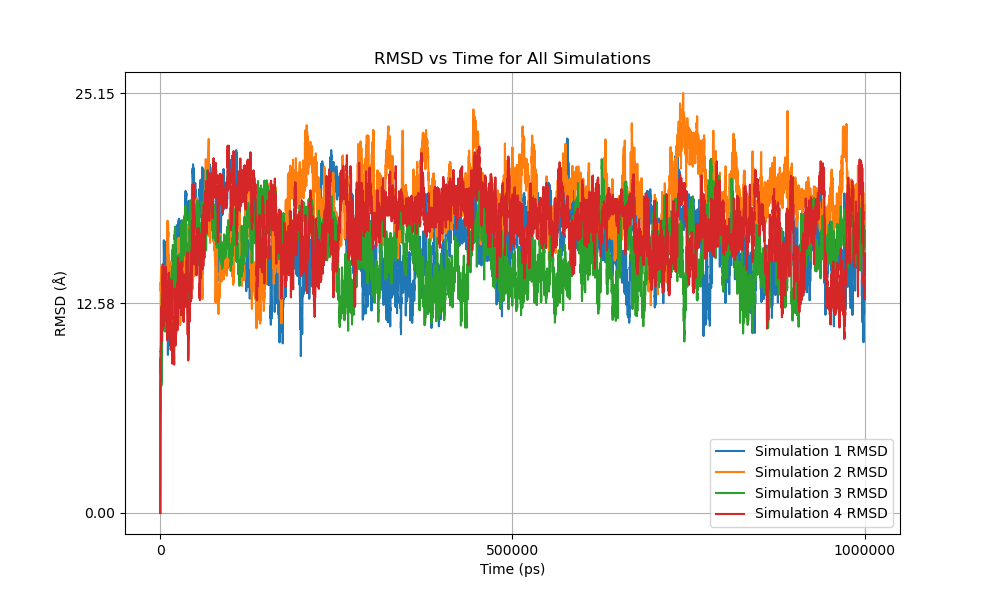

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import os
from IPython.display import Image, display

def save_and_display_overlapping_rmsd_plot(output_folder, num_simulations, plot_file='combined_rmsd_plot.png'):
    # Check if the plot already exists
    plot_path = os.path.join(output_folder, plot_file)
    
    if os.path.exists(plot_path):
        # If the plot exists, display it without regenerating
        print(f"Plot already exists: {plot_path}")
        display(Image(filename=plot_path))
    else:
        # Create a single figure for all plots
        plt.figure(figsize=(10, 6))
        
        all_rmsd_data = []  # To store all RMSD data for checking the global min/max
        # Loop through each simulation and plot its RMSD data on the same figure
        for i in range(1, num_simulations + 1):
            rmsd_file = os.path.join(output_folder, f'rmsd_data_simulation_{i}.dat')
            
            if os.path.exists(rmsd_file):
                # Load the RMSD data
                rmsd_data = pd.read_csv(rmsd_file, sep=r'\s+', header=None, names=['Frame', 'RMSD'])
                
                # Convert the frame number to time (ps), assuming 100 ps per frame
                rmsd_data['Time'] = pd.to_numeric(rmsd_data['Frame'], errors='coerce') * 100
                rmsd_data['RMSD'] = pd.to_numeric(rmsd_data['RMSD'], errors='coerce')  # Ensure RMSD is numeric
                
                # Drop any rows with NaN values (from conversion issues)
                rmsd_data.dropna(inplace=True)
                
                # Plot the RMSD data for this simulation
                plt.plot(rmsd_data['Time'], rmsd_data['RMSD'], label=f'Simulation {i} RMSD')
                
                # Append RMSD data for global min/max checks
                all_rmsd_data.append(rmsd_data)
            else:
                print(f"RMSD data file for simulation {i} not found.")
        
        # Set labels and title
        plt.xlabel('Time (ps)')
        plt.ylabel('RMSD (Å)')
        plt.title('RMSD vs Time for All Simulations')
        
        # Get x-axis (time) limits
        start_time = 0  # The starting time is always 0
        end_time = max(data['Time'].max() for data in all_rmsd_data)  # Get max time from all simulations
        midpoint_time = (start_time + end_time) / 2
        
        # Set custom x-axis ticks (start, midpoint, end)
        plt.xticks([start_time, midpoint_time, end_time], [f'{start_time:.0f}', f'{midpoint_time:.0f}', f'{end_time:.0f}'])
        
        # Get y-axis (RMSD) limits
        start_rmsd = min(data['RMSD'].min() for data in all_rmsd_data)
        end_rmsd = max(data['RMSD'].max() for data in all_rmsd_data)
        midpoint_rmsd = (start_rmsd + end_rmsd) / 2
        
        # Set custom y-axis ticks (start, midpoint, end)
        plt.yticks([start_rmsd, midpoint_rmsd, end_rmsd], [f'{start_rmsd:.2f}', f'{midpoint_rmsd:.2f}', f'{end_rmsd:.2f}'])
        
        # Add legend and grid
        plt.legend()
        plt.grid(True)
        
        # Save the figure
        plt.savefig(plot_path)
        plt.close()  # Close the plot to avoid displaying it twice
        
        print(f"Plot saved to {plot_path}")
        
        # Display the saved plot
        display(Image(filename=plot_path))

# Example usage
output_folder = 'RMSD_Check'
num_simulations = 4  # Assuming 4 simulations
save_and_display_overlapping_rmsd_plot(output_folder, num_simulations)


## Generating Trimmed Simulations

In [3]:
import os
import pandas as pd

# Function to find the frame where RMSD surpasses the minimum
def find_rmsd_cutoff_frame(rmsd_data):
    # Skip the first 5% of frames and find the minimum RMSD
    start_check_frame = int(len(rmsd_data) * 0.05)
    
    # Get the minimum RMSD from frames after the initial 5%
    min_rmsd_after_start = rmsd_data['RMSD'][start_check_frame:].min()
    
    # Find the first frame where the RMSD surpasses this minimum
    cutoff_frame = rmsd_data[rmsd_data['RMSD'] > min_rmsd_after_start].index[0]
    
    return cutoff_frame

# Display the selected frames for each simulation
def display_selected_frames(rmsd_folder, num_simulations):
    # Store the cutoff frames for all simulations
    cutoff_frames = []
    
    for i in range(1, num_simulations + 1):
        rmsd_file = os.path.join(rmsd_folder, f'rmsd_data_simulation_{i}.dat')
        
        if os.path.exists(rmsd_file):
            # Load the RMSD data
            rmsd_data = pd.read_csv(rmsd_file, sep=r'\s+', header=None, names=['Frame', 'RMSD'])
            rmsd_data['RMSD'] = pd.to_numeric(rmsd_data['RMSD'], errors='coerce')  # Ensure RMSD is numeric
            rmsd_data.dropna(inplace=True)
            
            # Find the cutoff frame for this simulation
            cutoff_frame = find_rmsd_cutoff_frame(rmsd_data)
            cutoff_frames.append(cutoff_frame)
            
            print(f"Simulation {i} selected frame: {cutoff_frame}")
        else:
            print(f"RMSD data file for simulation {i} not found.")
    
    # Use the largest cutoff frame for all simulations
    largest_cutoff_frame = max(cutoff_frames)
    print(f"Largest cutoff frame to be used for trimming: {largest_cutoff_frame}")

# Configuration
rmsd_folder = 'RMSD_Check'
num_simulations = 4  # Number of simulations

# Run the process to display the frame numbers
display_selected_frames(rmsd_folder, num_simulations)


Simulation 1 selected frame: 27
Simulation 2 selected frame: 7
Simulation 3 selected frame: 13
Simulation 4 selected frame: 13
Largest cutoff frame to be used for trimming: 27


In [4]:
import os
import subprocess
import pandas as pd

# Create folder for the trimmed simulation files
def setup_trimmed_folder(folder_name='Trimmed_Simulations'):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    return folder_name

# Function to find the frame where RMSD surpasses the minimum
def find_rmsd_cutoff_frame(rmsd_data):
    # Skip the first 5% of frames and find the minimum RMSD
    start_check_frame = int(len(rmsd_data) * 0.05)
    
    # Get the minimum RMSD from frames after the initial 5%
    min_rmsd_after_start = rmsd_data['RMSD'][start_check_frame:].min()
    
    # Find the first frame where the RMSD surpasses this minimum
    cutoff_frame = rmsd_data[rmsd_data['RMSD'] > min_rmsd_after_start].index[0]
    
    return cutoff_frame

# Generate the cpptraj script to split and save the trimmed trajectory
def write_trim_cpptraj_script(prmtop, trajectory, output_folder, simulation_index, start_frame, end_frame):
    output_file = os.path.join(output_folder, f'trimmed_simulation_{simulation_index}.nc')
    cpptraj_script = os.path.join(output_folder, f'trim_cpptraj_simulation_{simulation_index}.cpptraj')
    
    with open(cpptraj_script, 'w') as f:
        f.write(f"parm {prmtop}\n")
        f.write(f"trajin {trajectory} {start_frame} {end_frame}\n")  # Select frames from start to end
        f.write(f"trajout {output_file} netcdf\n")  # Save to new NetCDF file
        f.write("go\n")
    
    print(f"CPPTRAJ script for simulation {simulation_index} written to {cpptraj_script}")
    return cpptraj_script, output_file

# Trim and save all simulations using the largest starting frame
def trim_and_save_simulations(prmtop, trajectory, rmsd_files, output_folder, frames_per_simulation):
    # Store the cutoff frames for all simulations
    cutoff_frames = []
    
    for i, rmsd_file in enumerate(rmsd_files, start=1):
        # Load the RMSD data
        rmsd_data = pd.read_csv(rmsd_file, sep=r'\s+', header=None, names=['Frame', 'RMSD'])
        rmsd_data['RMSD'] = pd.to_numeric(rmsd_data['RMSD'], errors='coerce')  # Ensure RMSD is numeric
        rmsd_data.dropna(inplace=True)
        
        # Find the cutoff frame for this simulation
        cutoff_frame = find_rmsd_cutoff_frame(rmsd_data)
        cutoff_frames.append(cutoff_frame)
    
    # Use the largest cutoff frame for all simulations
    largest_cutoff_frame = max(cutoff_frames)
    print(f"Largest cutoff frame: {largest_cutoff_frame}")
    
    # Generate and run cpptraj scripts for all simulations
    for i, rmsd_file in enumerate(rmsd_files, start=1):
        start_frame = largest_cutoff_frame
        end_frame = frames_per_simulation  # Use the total number of frames per simulation
        
        # Check if the output file already exists
        output_file = os.path.join(output_folder, f'trimmed_simulation_{i}.nc')
        if os.path.exists(output_file):
            print(f"Trimmed simulation for {i} already exists.")
            continue  # Skip this simulation if the file already exists
        
        # Generate cpptraj script and save the trimmed simulation file
        cpptraj_script, output_file = write_trim_cpptraj_script(prmtop, trajectory, output_folder, i, start_frame, end_frame)
        
        # Run cpptraj to generate the new trimmed file
        subprocess.run(f"cpptraj -i {cpptraj_script}", shell=True)
        print(f"Trimmed simulation for {i} saved to {output_file}")

# Main function to process and trim simulations
def process_and_trim_simulations(prmtop, trajectory, rmsd_folder, total_frames, frames_per_simulation):
    # Set up folder for the trimmed simulation files
    output_folder = setup_trimmed_folder()
    
    # Check if all trimmed files already exist
    all_files_exist = all(os.path.exists(os.path.join(output_folder, f'trimmed_simulation_{i}.nc')) for i in range(1, 5))
    
    if all_files_exist:
        print("Trimmed simulations already finished.")
        return  # Exit the function if all files exist
    
    # Define the RMSD files for each simulation
    rmsd_files = [os.path.join(rmsd_folder, f'rmsd_data_simulation_{i}.dat') for i in range(1, 5)]
    
    # Trim and save the new simulation files using the largest cutoff frame
    trim_and_save_simulations(prmtop, trajectory, rmsd_files, output_folder, frames_per_simulation)

# Configuration
prmtop_1 = 'myc_091-160_stripped.prmtop'
nc_1 = 'aMD_091-160_no1-4_stripped.nc'  # Concatenated file
total_frames = 40000  # Total number of frames across all simulations
frames_per_simulation = 10000  # Each simulation has 10,000 frames

# Run the trimming process
process_and_trim_simulations(prmtop_1, nc_1, 'RMSD_Check', total_frames, frames_per_simulation)


Largest cutoff frame: 27
CPPTRAJ script for simulation 1 written to Trimmed_Simulations/trim_cpptraj_simulation_1.cpptraj

CPPTRAJ: Trajectory Analysis. V6.18.1 (AmberTools)
    ___  ___  ___  ___
     | \/ | \/ | \/ | 
    _|_/\_|_/\_|_/\_|_

| Date/time: 10/12/24 15:13:06
| Available memory: 90.339 GB

INPUT: Reading input from 'Trimmed_Simulations/trim_cpptraj_simulation_1.cpptraj'
  [parm myc_091-160_stripped.prmtop]
	Reading 'myc_091-160_stripped.prmtop' as Amber Topology
	Radius Set: modified Bondi radii (mbondi)
  [trajin aMD_091-160_no1-4_stripped.nc 27 10000]
	Reading 'aMD_091-160_no1-4_stripped.nc' as Amber NetCDF
  [trajout Trimmed_Simulations/trimmed_simulation_1.nc netcdf]
	Writing 'Trimmed_Simulations/trimmed_simulation_1.nc' as Amber NetCDF
  [go]
---------- RUN BEGIN -------------------------------------------------

PARAMETER FILES (1 total):
 0: myc_091-160_stripped.prmtop, 1037 atoms, 70 res, box: Orthorhombic, 1 mol

INPUT TRAJECTORIES (1 total):
 0: 'aMD_091-160_no

# Read in prmtop and tractory data and execute internal distance measurements
-----
### CPPTRAJ files saved in cpptraj_folder/
### LCCDATA files saved in lccdata_folder/

In [6]:
# Configuration for trimmed files
trimmed_files = [
    'Trimmed_Simulations/trimmed_simulation_1.nc',
    'Trimmed_Simulations/trimmed_simulation_2.nc',
    'Trimmed_Simulations/trimmed_simulation_3.nc',
    'Trimmed_Simulations/trimmed_simulation_4.nc'
]
prmtop_1 = 'myc_091-160_stripped.prmtop'
protein_length = 70
window_range = range(2, 52)


In [2]:
# Local Compaction Plot Generation Functions
def write_cpptraj_script(name, parmtop, trajectory, protein_length, window, cpptraj_folder, lccdata_folder):
    cpptraj_file = os.path.join(cpptraj_folder, f"{name}_distance_{window}.cpptraj")
    lccdata_file = os.path.join(lccdata_folder, f"{name}.lccdata")
    with open(cpptraj_file, "w") as f:
        f.write("parm ")
        f.write(parmtop)
        f.write("\n")
        f.write("trajin ")
        f.write(trajectory)
        f.write("\n")
        upper_limit = protein_length + 1 - window
        for x in range(1, upper_limit):
            f.write(f"distance :{x} :{x + window} out {lccdata_file}\n")

def setup_folders(simulation_index):
    cpptraj_folder = f'cpptraj_files/cpptraj_files_simulation_{simulation_index}'
    lccdata_folder = f'lccdata_files/lccdata_files_simulation_{simulation_index}'
    
    cpptraj_exists = os.path.isdir(cpptraj_folder) and len(os.listdir(cpptraj_folder)) > 0
    lccdata_exists = os.path.isdir(lccdata_folder) and len(os.listdir(lccdata_folder)) > 0
    
    if cpptraj_exists and lccdata_exists:
        print(f"cpptraj files and lccdata_files already generated for simulation {simulation_index}.")
        return cpptraj_folder, lccdata_folder, False
    elif cpptraj_exists:
        print(f"cpptraj files already generated for simulation {simulation_index}.")
    elif lccdata_exists:
        print(f"lccdata files already generated for simulation {simulation_index}.")
    
    if not cpptraj_exists:
        os.makedirs(cpptraj_folder, exist_ok=True)
    if not lccdata_exists:
        os.makedirs(lccdata_folder, exist_ok=True)
    
    return cpptraj_folder, lccdata_folder, True


def execute_cpptraj_scripts(prmtop_1, trajectory, protein_length, window_range, simulation_index):
    cpptraj_folder, lccdata_folder, should_proceed = setup_folders(simulation_index)
    if not should_proceed:
        return  # Stop execution if folders exist and have content
    
    for window in window_range:
        write_cpptraj_script(f"wildtype_simulation_{simulation_index}_window_{window}", prmtop_1, trajectory, protein_length, window, cpptraj_folder, lccdata_folder)

def execute_cpptraj_commands(simulation_index, window_range):
    cpptraj_folder, lccdata_folder, should_proceed = setup_folders(simulation_index)  
    if not should_proceed:
        return  # Stop execution if lccdata_files already generated and have content

    for window in tqdm(window_range, desc=f"Generating LCCData files for simulation {simulation_index}"):
        wildtype_file = f"{cpptraj_folder}/wildtype_simulation_{simulation_index}_window_{window}_distance_{window}.cpptraj"
        
        wildtype_command = f"cpptraj < {wildtype_file}"
        
        subprocess.run(wildtype_command, shell=True, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)

    print(f"LCCData files generated for simulation {simulation_index}.")

In [3]:
# Setup folders and execute scripts for each simulation
def process_simulation(prmtop_1, trimmed_file, protein_length, window_range, simulation_index):
    cpptraj_folder, lccdata_folder, should_proceed = setup_folders(simulation_index)
    if should_proceed:
        execute_cpptraj_scripts(prmtop_1, trimmed_file, protein_length, window_range, simulation_index)
    else:
        print(f"No need to regenerate cpptraj scripts or lccdata files for simulation {simulation_index}.")


In [4]:
# Create LCCDATA files for each simulation using trimmed files
def create_lccdata_files(simulation_index, window_range):
    execute_cpptraj_commands(simulation_index, window_range)

# Load LCCDATA and attach to variables

In [2]:
# Import LCC Data
window_range = range(2, 52)


def import_lcc_data(lccdata_folder, prefix):
    """
    Imports LCC data files for a given prefix (wild type or mutant protein) and assigns to a dictionary.

    Parameters:
    - lccdata_folder: The folder where LCC data files are stored.
    - prefix: The prefix used to identify the files for either the wild type or mutant (e.g., 'w' for wild type).

    Returns:
    - A dictionary with window sizes as keys and pandas DataFrames as values.
    """
    files = glob.glob(f'{lccdata_folder}/{prefix}*.lccdata')
    files.sort(key=lambda x: [int(part) if part.isdigit() else part for part in re.split(r'(\d+)', x)])

    window_range = list(range(2, 52))
    data_dict = {}
    for window, file in zip(window_range, files):
        data_dict[window] = pd.DataFrame(np.loadtxt(file)).drop(columns=0)
    
    return data_dict

lccdata_folder = f'lccdata_files/lccdata_files_simulation_[simulation_number]'

# Import LCC data files for wild type protein and mutant protein
wt_dict = import_lcc_data(lccdata_folder, 'wildtype')


# Create Local Compaction Plots

In [8]:
# Create local compaction plots for each simulation using trimmed files
def LCC_plot_individual(window, wt, simulation_index):
    """
    Creates and saves an LCC plot for wt data for a specific window size.
    """
    save_folder = f'local_compaction_plots/local_compaction_plots_simulation_{simulation_index}'
    
    # Check if the save folder exists and has files for all window sizes.
    if os.path.isdir(save_folder) and len(os.listdir(save_folder)) == 50:
        print(f"Local compaction plots already generated and saved in '{save_folder}'")
        return

    plt.figure(figsize=(15, 10))  # Create a new figure for each plot
    ax = plt.gca()  

    wt = wt.to_numpy()
    frame_number_wt = wt.shape[0]
    upper_limit = 70 + 1 - window  # max protein length + 1

    for z in range(1, frame_number_wt, 10):
        y = wt[z]
        y_length = len(y)
        x = np.linspace(1 + window / 2 + 90, upper_limit + window / 2 + 90, y_length)

        ax.plot(x, y, color='blue', alpha=0.002)

    ax.set_xlabel('Amino Acid Sequence Position')
    ax.set_ylabel(r'Distance ($\AA$)')
    plot_name = f'Sequence Distance Distribution: Window Size {window} aa'
    ax.set_title(plot_name)

    os.makedirs(save_folder, exist_ok=True)
    save_path = os.path.join(save_folder, f'LCC_Plot_{window}.png')
    plt.savefig(save_path)
    plt.close()

In [9]:
# Generate local compaction plots for each simulation using trimmed files
def generate_plots_for_simulation(simulation_index, window_range, wt_dict):
    save_folder = f'local_compaction_plots/local_compaction_plots_simulation_{simulation_index}'
    
    if not (os.path.isdir(save_folder) and len(os.listdir(save_folder)) == 50):
        for window in window_range:
            LCC_plot_individual(window, wt_dict[window], simulation_index)
    else:
        print(f"Local compaction plots already generated and saved in '{save_folder}'")


In [10]:
# Process and generate files for each simulation
for simulation_index, trimmed_file in enumerate(trimmed_files, start=1):
    process_simulation(prmtop_1, trimmed_file, protein_length, window_range, simulation_index)
    create_lccdata_files(simulation_index, window_range)

    # Import LCC data and generate plots
    lccdata_folder = f'lccdata_files/lccdata_files_simulation_{simulation_index}'
    wt_dict = import_lcc_data(lccdata_folder, 'wildtype')
    generate_plots_for_simulation(simulation_index, window_range, wt_dict)

cpptraj files already generated for simulation 1.


Generating LCCData files for simulation 1: 100%|█| 50/50 [00:05<00:00,  8.49it/s


LCCData files generated for simulation 1.
cpptraj files already generated for simulation 2.


Generating LCCData files for simulation 2: 100%|█| 50/50 [00:05<00:00,  8.52it/s


LCCData files generated for simulation 2.
cpptraj files already generated for simulation 3.


Generating LCCData files for simulation 3: 100%|█| 50/50 [00:05<00:00,  8.55it/s


LCCData files generated for simulation 3.
cpptraj files already generated for simulation 4.


Generating LCCData files for simulation 4: 100%|█| 50/50 [00:05<00:00,  8.59it/s


LCCData files generated for simulation 4.


# XGBoost Feature Selection

In [3]:
# Function to concatenate data from multiple simulations
def concatenate_simulation_data(simulations, window_range):
    concatenated_data = {}
    for window in window_range:
        # Concatenate the data for each window from all simulations
        concatenated_data[window] = pd.concat([sim[window] for sim in simulations], axis=0).reset_index(drop=True)
    return concatenated_data

# Import LCC data for simulations 1 to 4
lccdata_folder_1 = 'lccdata_files/lccdata_files_simulation_1'
lccdata_folder_2 = 'lccdata_files/lccdata_files_simulation_2'
lccdata_folder_3 = 'lccdata_files/lccdata_files_simulation_3'
lccdata_folder_4 = 'lccdata_files/lccdata_files_simulation_4'

# Load the data for each simulation
wt_dict_sim_1 = import_lcc_data(lccdata_folder_1, 'wildtype')
wt_dict_sim_2 = import_lcc_data(lccdata_folder_2, 'wildtype')
wt_dict_sim_3 = import_lcc_data(lccdata_folder_3, 'wildtype')
wt_dict_sim_4 = import_lcc_data(lccdata_folder_4, 'wildtype')

# Concatenate simulations 1 and 2 into wt_dict_1_2, and simulations 3 and 4 into wt_dict_3_4
wt_dict_1_2 = concatenate_simulation_data([wt_dict_sim_1, wt_dict_sim_2], window_range)
wt_dict_3_4 = concatenate_simulation_data([wt_dict_sim_3, wt_dict_sim_4], window_range)

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from kneed import KneeLocator

class XGBoostTrainer:
    def __init__(self, wt_dict_1_2, wt_dict_3_4, window_sizes, default_hyperparameters, eta_values, max_depth_values, subsample_values):
        self.wt_dict_1_2 = wt_dict_1_2
        self.wt_dict_3_4 = wt_dict_3_4
        self.window_sizes = window_sizes
        self.default_hyperparameters = default_hyperparameters
        self.eta_values = eta_values
        self.max_depth_values = max_depth_values
        self.subsample_values = subsample_values
        self.best_hyperparameters = {}
        self.default_accuracy_values = {}
        self.best_accuracy_values = {}
        self.elbow_thresholds = {}
        self.main_folder = 'XGBoost'
        os.makedirs(self.main_folder, exist_ok=True)  # Create the main XGBoost folder
        self.graph_save_path = os.path.join(self.main_folder, 'XGB_Tuning_Graphs')
        os.makedirs(self.graph_save_path, exist_ok=True)

    @staticmethod
    def unison_shuffled_copies(a, b):
        assert len(a) == len(b)
        p = np.random.permutation(len(a))
        return a[p], b[p]

    def prepare_data(self, window_size):
        wildtype_1_2_data = self.wt_dict_1_2[window_size]
        wildtype_1_2_label = np.zeros(len(wildtype_1_2_data))
        wildtype_3_4_data = self.wt_dict_3_4[window_size]
        wildtype_3_4_label = np.ones(len(wildtype_3_4_data))

        lcc_data = np.vstack((wildtype_1_2_data, wildtype_3_4_data))
        label_data = np.hstack((wildtype_1_2_label, wildtype_3_4_label))
        lcc_data, label_data = self.unison_shuffled_copies(lcc_data, label_data)
        lcc_data /= 100
        upper_training_limit = int(len(lcc_data) * 0.8)

        return lcc_data[:upper_training_limit], label_data[:upper_training_limit], lcc_data[upper_training_limit:], label_data[upper_training_limit:]

    def train_and_evaluate(self, train_data, train_label, test_data, test_label, **hyperparameters):
        model = XGBClassifier(**hyperparameters)
        model.fit(train_data, train_label)
        predictions = model.predict(test_data)
        return accuracy_score(test_label, predictions)

    def tune_hyperparameters(self):
        best_eta = None
        best_max_depth = None
        best_subsample = None
        best_accuracy = 0
        
        for eta in self.eta_values:
            for max_depth in self.max_depth_values:
                for subsample in self.subsample_values:
                    current_hyperparameters = self.default_hyperparameters.copy()
                    current_hyperparameters['learning_rate'] = eta
                    current_hyperparameters['max_depth'] = max_depth
                    current_hyperparameters['subsample'] = subsample
                    
                    total_accuracy = 0
                    
                    for window_size in self.window_sizes:
                        train_data, train_label, test_data, test_label = self.prepare_data(window_size)
                        accuracy = self.train_and_evaluate(train_data, train_label, test_data, test_label, **current_hyperparameters)
                        total_accuracy += accuracy
                    
                    avg_accuracy = total_accuracy / len(self.window_sizes)
                    
                    if avg_accuracy > best_accuracy:
                        best_accuracy = avg_accuracy
                        best_eta = eta
                        best_max_depth = max_depth
                        best_subsample = subsample
        
        # Save the best hyperparameters and print them
        self.best_hyperparameters = {
            'learning_rate': best_eta,
            'max_depth': best_max_depth,
            'subsample': best_subsample
        }
        print(f"Best Hyperparameters: learning_rate={best_eta}, max_depth={best_max_depth}, subsample={best_subsample}")
        print(f"Best Average Accuracy: {best_accuracy}")
        
        # Save best accuracy for future use
        self.best_accuracy_values = best_accuracy

    def save_feature_importance_and_plot(self):
        completed_trials = []
        for trial in range(1, 6):
            feature_importances_folder = os.path.join(self.main_folder, f'XGB_Position_Importance_Values_Trial_{trial}')
            if os.path.exists(feature_importances_folder) and os.listdir(feature_importances_folder):
                completed_trials.append(trial)

        if len(completed_trials) == 5:
            print("Feature Importance for trials 1-5 already generated")
            return
        elif completed_trials:
            print(f"Feature importance for trials {'-'.join(map(str, completed_trials))} already generated, running trials {completed_trials[-1]+1}-5 now.")
            start_trial = completed_trials[-1] + 1
        else:
            start_trial = 1

        for trial in range(start_trial, 6):
            feature_importances_folder = os.path.join(self.main_folder, f'XGB_Position_Importance_Values_Trial_{trial}')
            feature_importance_plot_folder = os.path.join(self.main_folder, f'XGB_Pos_Imp_Figs_Trial_{trial}')

            os.makedirs(feature_importances_folder, exist_ok=True)
            os.makedirs(feature_importance_plot_folder, exist_ok=True)

            # Use the tuned hyperparameters for all trials
            common_hyperparameters = self.best_hyperparameters.copy()

            for window_size in self.window_sizes:
                train_data, train_label, _, _ = self.prepare_data(window_size)
                model = XGBClassifier(**common_hyperparameters)
                model.fit(train_data, train_label)

                importances = model.feature_importances_

                positions = np.arange(1, len(importances) + 1)
                df_importances = pd.DataFrame({'Position': positions, 'Importance': importances})
                importance_file_path = os.path.join(feature_importances_folder, f'Feature_Importance_WS_{window_size}.csv')
                df_importances.to_csv(importance_file_path, index=False)

                fig, ax = plt.subplots(figsize=(9, 6))
                indices = np.arange(len(importances))
                ax.bar(indices, importances, color='#0504aa')
                ax.set_title(f'Feature Importance Values for Window Size {window_size}')
                ax.grid(True)
                ax.set_xlabel('Feature')
                ax.set_ylabel('Feature Importance')
                ax.set_ylim(0, np.max(importances) * 1.1)
                plot_path = os.path.join(feature_importance_plot_folder, f'Feature_Importance_{window_size}.png')
                fig.savefig(plot_path)
                plt.close(fig)

    def read_feature_importances(self, window_size, trial_number):
        feature_importances_folder = os.path.join(self.main_folder, f'XGB_Position_Importance_Values_Trial_{trial_number}')
        importance_file_path = os.path.join(feature_importances_folder, f'Feature_Importance_WS_{window_size}.csv')
        if os.path.exists(importance_file_path):
            return pd.read_csv(importance_file_path)
        else:
            print(f"No feature importances file found for window size {window_size}.")
            return pd.DataFrame({'Position': [], 'Importance': []})

    def run_analysis(self, trial_number):
        first_threshold, last_threshold, step_size = self.find_thresholds(trial_number)
        importance_thresholds = np.linspace(first_threshold, last_threshold, 81)[::1]
        elbow_threshold = self.calculate_and_plot_positions(importance_thresholds, trial_number)
        return elbow_threshold

    def find_thresholds(self, trial_number):
        max_adjusted_threshold = 0
        min_adjusted_threshold = float('inf')

        for window_size in self.window_sizes:
            df_importances = self.read_feature_importances(window_size, trial_number)
            if not df_importances.empty:
                df_importances['AdjustedImportance'] = df_importances['Importance'] * (70 - window_size) / 68
                max_importance = df_importances['AdjustedImportance'].max()
                min_importance = df_importances[df_importances['Importance'] > 0]['AdjustedImportance'].min()
                if max_importance > max_adjusted_threshold:
                    max_adjusted_threshold = max_importance
                if min_importance < min_adjusted_threshold:
                    min_adjusted_threshold = min_importance

        step_size = (max_adjusted_threshold - min_adjusted_threshold) / 80
        return max_adjusted_threshold, min_adjusted_threshold, step_size

    def calculate_and_plot_positions(self, importance_thresholds, trial_number):
        total_positions_by_threshold = {}
        previous_covered_positions = set()

        # Create directory for residue coverage graphs if it doesn't exist
        output_dir = os.path.join(self.main_folder, f'Residue_Coverage_Trial_{trial_number}')
        os.makedirs(output_dir, exist_ok=True)

        for threshold in importance_thresholds:
            total_positions = 0
            current_covered_positions = set()

            # Initiate plot for residue coverage, but do not show, only save
            plt.figure(figsize=(10, 6))

            for window_size in self.window_sizes:
                adjusted_threshold = self.calculate_adjusted_threshold(threshold, window_size)
                df_importances = self.read_feature_importances(window_size, trial_number)

                if not df_importances.empty:
                    important_features = df_importances[df_importances['Importance'] >= adjusted_threshold]['Position']
                    total_positions += len(important_features)

                    for feature in important_features:
                        start_residue = feature + 90
                        end_residue = start_residue + window_size
                        current_position_range = (start_residue, end_residue)
                        current_covered_positions.add(current_position_range)

                        color = 'blue' if current_position_range in previous_covered_positions else 'red'
                        plt.plot([start_residue, end_residue], [window_size, window_size], color=color, marker='o', markersize=5, linewidth=2)

            new_positions = current_covered_positions - previous_covered_positions
            previous_covered_positions.update(current_covered_positions)
            total_positions_by_threshold[threshold] = total_positions

            # Finalize and save the plot for the current threshold
            plt.title(f'Residues Covered for Threshold {threshold:.4f}')
            plt.xlabel('Residue Position')
            plt.ylabel('Window Size')
            plt.xlim(91, 160)
            plt.ylim(0, 51)
            plt.xticks(range(91, 161, 5))
            plt.yticks(range(0, 52, 2))
            plt.grid(True)
            plt.savefig(os.path.join(output_dir, f'Residue_Coverage_Threshold_{threshold:.4f}.png'))
            plt.close()

        # After processing all thresholds, determine the elbow threshold
        thresholds = sorted(total_positions_by_threshold.keys())
        total_positions = [total_positions_by_threshold[threshold] for threshold in thresholds]

        plt.figure(figsize=(10, 6))
        plt.plot(thresholds, total_positions, '-o', color='blue')

        kneedle = KneeLocator(thresholds, total_positions, curve='convex', direction='decreasing', interp_method='polynomial')
        elbow_threshold = kneedle.elbow
        elbow_total_positions = kneedle.elbow_y

        plt.scatter(elbow_threshold, elbow_total_positions, color='red', s=100, label=f'Elbow at {elbow_threshold:.3f}', zorder=5)
        plt.title(f'Total Positions Above Threshold - Elbow Threshold: {elbow_threshold:.4f}')
        plt.xlabel('Importance Threshold')
        plt.ylabel('Total Number of Positions Above Threshold')
        plt.grid(True)
        plt.gca().invert_xaxis()
        plt.show()

        print(f"Elbow Threshold: {elbow_threshold:.4f}")
        print(f"Positions Above Elbow Threshold: {elbow_total_positions}")
        
        self.elbow_thresholds[trial_number] = elbow_threshold
        return elbow_threshold
    
    def get_important_positions(self, elbow_threshold, trial_number):
        important_positions_all_windows = {}
        for window_size in self.window_sizes:
            adjusted_threshold = self.calculate_adjusted_threshold(elbow_threshold, window_size)
            df_importances = self.read_feature_importances(window_size, trial_number)
            if not df_importances.empty:
                important_positions = df_importances[df_importances['Importance'] >= adjusted_threshold]['Position'].unique()
                important_positions_all_windows[window_size] = set(important_positions)
        return important_positions_all_windows

    def calculate_adjusted_threshold(self, importance_threshold, window_size):
        return importance_threshold * (68 / (70 - window_size))

    def run_analysis_for_all_trials(self):
        all_trials_positions = []
        for trial_number in range(1, 6):
            elbow_threshold = self.run_analysis(trial_number)
            important_positions = self.get_important_positions(elbow_threshold, trial_number)
            all_trials_positions.append(important_positions)

        common_positions = self.find_common_positions(all_trials_positions)
        self.save_common_positions_above_threshold(common_positions)
        
    def find_common_positions(self, all_trials_positions):
        common_positions = {}
        for window_size in self.window_sizes:
            window_specific_positions = [trial_positions.get(window_size, set()) for trial_positions in all_trials_positions]
            common_positions[window_size] = set.intersection(*window_specific_positions)
        return common_positions
        
    def save_common_positions_above_threshold(self, common_positions):
        output_folder = 'XGB_Filtered_Common_Positions'  # This remains outside of the XGBoost folder
        os.makedirs(output_folder, exist_ok=True)
        
        for window_size, positions in common_positions.items():
            if positions:
                wt_1_2_filtered_data = self.wt_dict_1_2[window_size].filter(items=list(positions), axis='columns')
                wt_1_2_filtered_data.to_csv(os.path.join(output_folder, f'wt_1_2_{window_size}f.csv'), index_label='Index')
                wt_3_4_filtered_data = self.wt_dict_3_4[window_size].filter(items=list(positions), axis='columns')
                wt_3_4_filtered_data.to_csv(os.path.join(output_folder, f'wt_3_4_{window_size}f.csv'), index_label='Index')

    def display_residue_coverage_at_elbow(self):
        for trial_number, elbow_threshold in self.elbow_thresholds.items():
            # Define the file path for the stored graph
            file_path = os.path.join(self.main_folder, f'Residue_Coverage_Trial_{trial_number}', f'Residue_Coverage_Threshold_{elbow_threshold:.4f}.png')

            # Check if the file exists to avoid errors
            if os.path.exists(file_path):
                img = plt.imread(file_path)
                plt.figure(figsize=(10, 6))
                plt.imshow(img)
                plt.axis('off')
                plt.show()
            else:
                print(f'File {file_path} not found.')

Best Hyperparameters: learning_rate=0.8, max_depth=6, subsample=0.6
Best Average Accuracy: 0.2991629072681705


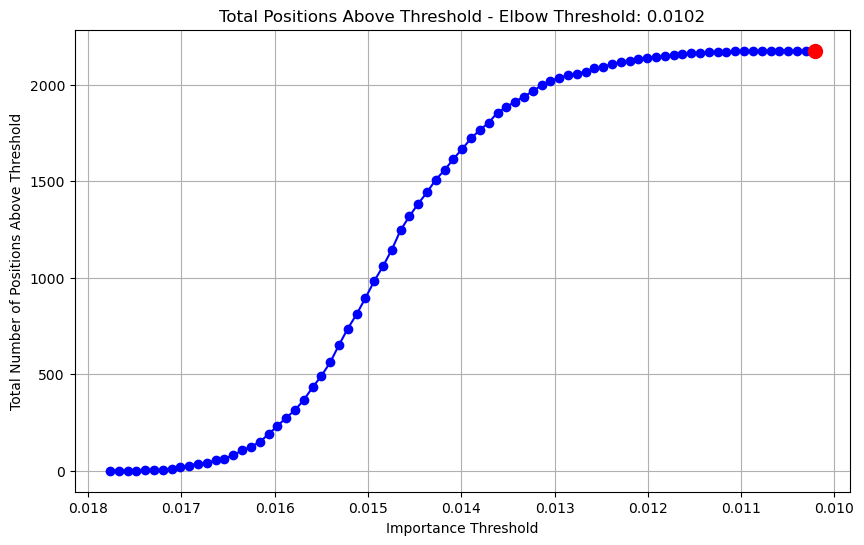

Elbow Threshold: 0.0102
Positions Above Elbow Threshold: 2175


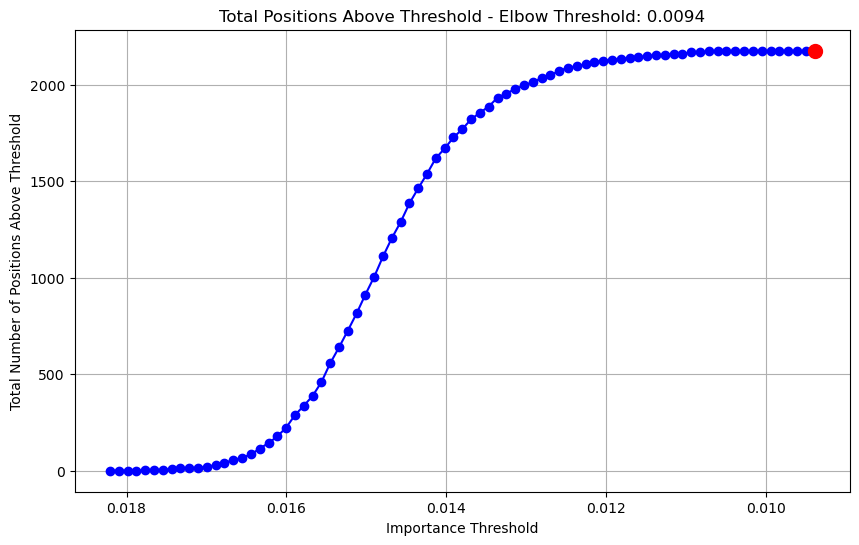

Elbow Threshold: 0.0094
Positions Above Elbow Threshold: 2175


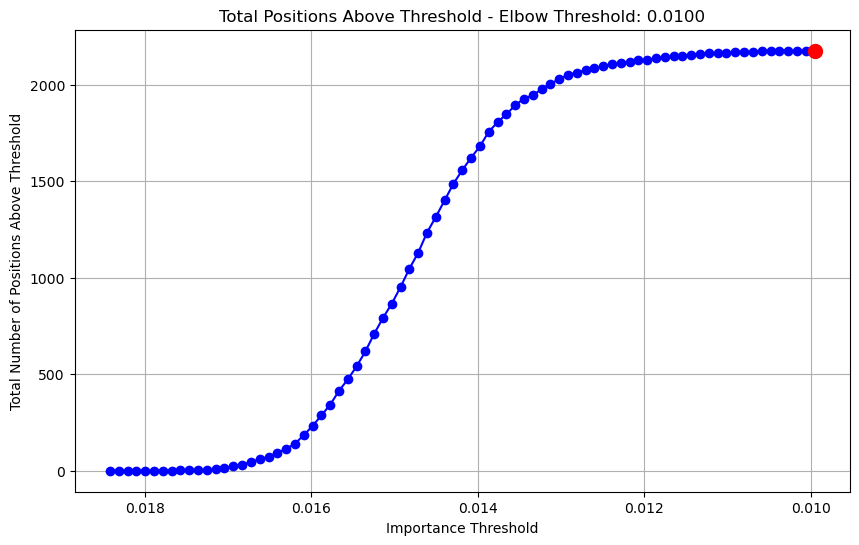

Elbow Threshold: 0.0100
Positions Above Elbow Threshold: 2175


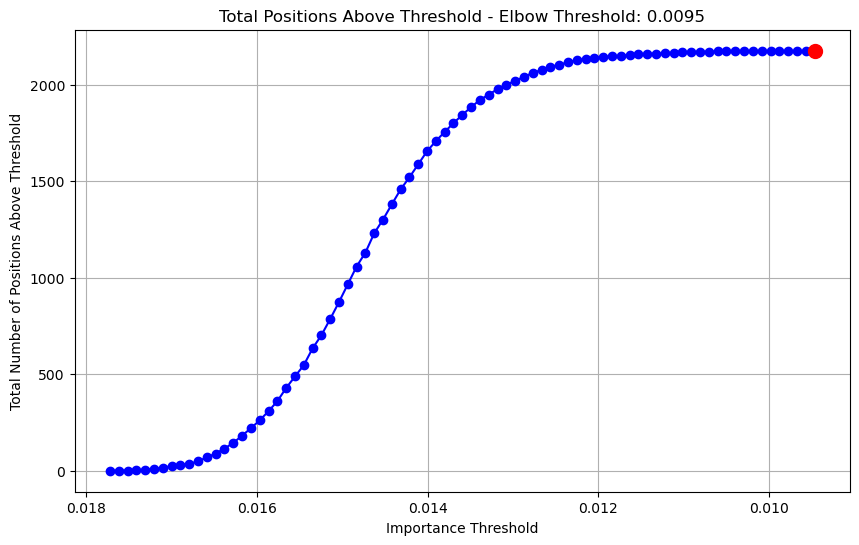

Elbow Threshold: 0.0095
Positions Above Elbow Threshold: 2175


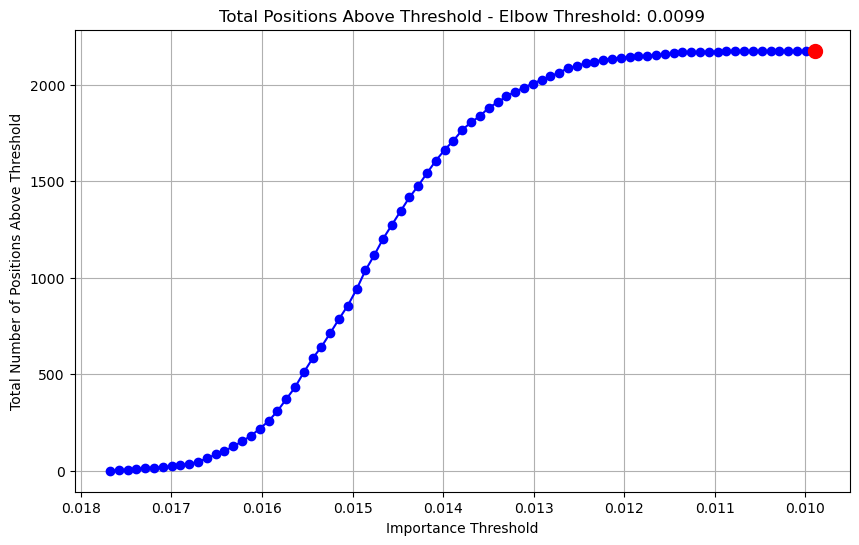

Elbow Threshold: 0.0099
Positions Above Elbow Threshold: 2175


In [5]:
window_sizes = range(2, 52)

# Default hyperparameters for XGBClassifier
default_hyperparameters = {
    'n_estimators': 100,       # Default is 100 trees
    'learning_rate': 0.3,      # Default learning rate is 0.3
    'max_depth': 6,            # Default maximum depth of trees is 6
    'subsample': 1.0,          # Default is 1.0 (use all data instances)
    'colsample_bytree': 1.0,   # Default is 1.0 (use all features)
    'gamma': 0,                # Default gamma is 0 (no minimum loss reduction)
    'reg_alpha': 0,            # Default L1 regularization is 0
    'reg_lambda': 1,           # Default L2 regularization is 1
    'random_state': 0          # Default random seed is 0
}

eta_values = [0.2, 0.4, 0.6, 0.8]  # Learning rates to test
max_depth_values = [6, 12, 18, 24]      # Max depths to test
subsample_values = [0.6, 0.7, 0.8, 0.9]  # Subsampling ratios to test

# Initialize the trainer
trainer = XGBoostTrainer(wt_dict_1_2, wt_dict_3_4, window_sizes, default_hyperparameters, eta_values, max_depth_values, subsample_values)

# 1. Tune hyperparameters
trainer.tune_hyperparameters()

# 2. Evaluate feature importance with tuned hyperparameters
trainer.save_feature_importance_and_plot()

# 3. Run additional analyses if needed
trainer.run_analysis_for_all_trials()

In [6]:
print(lcc_data)

NameError: name 'lcc_data' is not defined

# Data Preparation for Dimension Reduction

In [ ]:
import os
import pandas as pd
from sklearn.model_selection import KFold

def save_datasets(X_train, y_train, X_valid, y_valid, fold):
    folder_name = f'Training_Set_{fold}'
    os.makedirs(folder_name, exist_ok=True)
    
    X_train.to_csv(os.path.join(folder_name, 'X_train_f.csv'))
    y_train.to_csv(os.path.join(folder_name, 'y_train_f.csv'))
    X_valid.to_csv(os.path.join(folder_name, 'X_valid_f.csv'))
    y_valid.to_csv(os.path.join(folder_name, 'y_valid_f.csv'))

def load_datasets(fold):
    folder_name = f'Training_Set_{fold}'
    
    X_train = pd.read_csv(os.path.join(folder_name, 'X_train_f.csv'), index_col='Index')
    y_train = pd.read_csv(os.path.join(folder_name, 'y_train_f.csv'), index_col='Index')
    X_valid = pd.read_csv(os.path.join(folder_name, 'X_valid_f.csv'), index_col='Index')
    y_valid = pd.read_csv(os.path.join(folder_name, 'y_valid_f.csv'), index_col='Index')
    
    return X_train, y_train, X_valid, y_valid

def load_and_concatenate(file_prefix, window_sizes):
    dataframes = []
    for window_size in window_sizes:
        filepath = f'{filtered_data_folder_name}/{file_prefix}_{window_size}f.csv'
        df = pd.read_csv(filepath, index_col='Index')
        dataframes.append(df)
    return pd.concat(dataframes, axis=1)

def preprocessing_kfold(wt_data, n_splits=5):
    # Ensure all data is numeric
    wt_data = wt_data.apply(pd.to_numeric, errors='coerce')

    # Shuffle the DataFrame rows without resetting the index
    wt_data = wt_data.sample(frac=1, random_state=42)
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold = 1
    for train_index, valid_index in kf.split(wt_data):
        folder_name = f'Training_Set_{fold}'
        if not os.path.exists(os.path.join(folder_name, 'X_train_f.csv')):
            X_train, X_valid = wt_data.iloc[train_index], wt_data.iloc[valid_index]
            y_train, y_valid = pd.DataFrame({'class': [0]*len(X_train)}, index=X_train.index), pd.DataFrame({'class': [0]*len(X_valid)}, index=X_valid.index)

            # Normalize training data
            X_train = X_train.div(100)
            X_valid = X_valid.div(100)

            print(f"Fold {fold}:")
            print(f"Training set shape: {X_train.shape}")
            print(f"Validation set shape: {X_valid.shape}")
            
            save_datasets(X_train, y_train, X_valid, y_valid, fold)
        else:
            print(f"Data for fold {fold} already exists, skipping generation.")
        fold += 1

In [ ]:
filtered_data_folder_name = 'WildType_WS_4_14_24_34_44'

# Window sizes to be used
window_sizes = [4, 14, 24, 34, 44]

# Import and Prep Data
wt_f = load_and_concatenate('wt', window_sizes)

# Preprocessing and creating 5 sets of training/validation data
preprocessing_kfold(wt_f, n_splits=5)

# Example of loading a specific fold (e.g., fold 1)
X_train_loaded, y_train_loaded, X_valid_loaded, y_valid_loaded = load_datasets(fold=1)

# Autoencoder Training
----
Note: 
- Autoencoder tuned on 91-160C-Myc below. See Autoencoder_Tuning
- 4 Autoencoders trained separately on the same test-train split

In [ ]:
# Save the model using the recommended Keras format
def save_model(model, model_path):
    if not model_path.endswith('.keras'):
        model_path += '.keras'
    model.save(model_path)
    
# Load the model
def load_existing_model(model_path):
    return load_model(model_path)

In [ ]:
# Get autoencoder model
def AE_Model(train_data, LeReLU_alpha=0.01, batch_size=153):
    
    input_layer = Input(shape=(train_data.shape[1]), name='ae_input')
    
    encoder = Dense(672, activation=relu, name='e1')(input_layer)
    encoder = Dense(32, activation=LeakyReLU(alpha=LeReLU_alpha), name='e2')(encoder)
    encoder = Dense(672, activation=LeakyReLU(alpha=LeReLU_alpha), name='e3')(encoder)
    encoder = Dense(352, activation=LeakyReLU(alpha=LeReLU_alpha), name='e4')(encoder)
    encoder = Dense(32, activation=relu, name='e5')(encoder)
    encoder = Dense(32, activation=LeakyReLU(alpha=LeReLU_alpha), name='e6')(encoder)

    encoded = Dense(2, activation='linear', name='ae_latent')(encoder)
    
    decoder = Dense(32, activation=LeakyReLU(alpha=LeReLU_alpha), name='d6')(encoded)
    decoder = Dense(32, activation=relu, name='d5')(decoder)
    decoder = Dense(352, activation=LeakyReLU(alpha=LeReLU_alpha), name='d4')(decoder)
    decoder = Dense(672, activation=LeakyReLU(alpha=LeReLU_alpha), name='d3')(decoder)
    decoder = Dense(32, activation=LeakyReLU(alpha=LeReLU_alpha), name='d2')(decoder)
    decoder = Dense(672, activation=relu, name='d1')(decoder)

    output_layer = Dense(train_data.shape[1], activation='linear', name='ae_output')(decoder)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer=Adam(learning_rate=1e-5), loss=MeanSquaredError())
    
    model.summary()
    
    return model

In [ ]:
# Create the directory if it does not exist
output_dir = 'AE_Training_1'
os.makedirs(output_dir, exist_ok=True)

# Initialize the autoencoder with the loaded training data
autoencoder = AE_Model(X_train_loaded)

for counts in tqdm(range(21)):
    name = "Autoencoder_Training"
    output_path = os.path.join(output_dir,  f"{counts}_Latent_Space_Predictions_Log.txt")
    with open(output_path, "w") as file:
        history = autoencoder.fit(X_train_loaded, X_train_loaded, epochs=1000, validation_data=(X_valid_loaded, X_valid_loaded), verbose=2)

        training_history = pd.DataFrame(history.history)
        plt.plot(training_history)
        file_name_0 = os.path.join(output_dir, str(counts) + "_" + name + "_History")
        training_history.to_pickle(file_name_0)
        file_name_1 = os.path.join(output_dir, str(counts) + "_" + name + "_History.png")
        plt.savefig(file_name_1, dpi=300)
        plt.clf()

        dr_model = tf.keras.models.Model(inputs=autoencoder.get_layer('ae_input').input,
                                         outputs=autoencoder.get_layer('ae_latent').output)
        dr_model.summary(print_fn=lambda x: file.write(x + '\n'))

        batch_size = 32
        x = []
        y = []
        z = []
        indices = []

        # Process validation data in batches
        for batch_start in range(0, len(X_valid_loaded), batch_size):
            batch_end = min(batch_start + batch_size, len(X_valid_loaded))
            X_batch = np.array(X_valid_loaded.iloc[batch_start:batch_end])
            y_batch = y_valid_loaded.iloc[batch_start:batch_end].values.flatten()

            # Make predictions for this batch
            op_batch = dr_model.predict(X_batch, verbose=0)

            # Process and store the results
            for i, op in enumerate(op_batch):
                z.append(y_batch[i])
                x.append(op[0])
                y.append(op[1])
                indices.append(y_valid_loaded.index[batch_start + i])
                file.write(f"Prediction {batch_start + i}: {op}\n")

        # Construct and save the data frame
        df = pd.DataFrame()
        df['x'] = x
        df['y'] = y
        df['z'] = ["trajectory-" + str(k) for k in z]
        df['index'] = indices

        plt.figure(figsize=(8, 6))
        fig = sns.scatterplot(x='x', y='y', hue='z', data=df, s=10)
        file_name_2 = os.path.join(output_dir, str(counts) + "_Latent_Space.png")
        fig.figure.savefig(file_name_2, dpi=300)
        plt.clf()

        file_name_3 = os.path.join(output_dir, str(counts) + '_Latent_Space')
        df.to_pickle(file_name_3)

        # Save the model in a folder within the designated directory
        model_dir = os.path.join(output_dir, 'models')
        os.makedirs(model_dir, exist_ok=True)
        file_name = os.path.join(model_dir, 'saved_model_' + str(counts))
        save_model(autoencoder, file_name)

In [ ]:
# Create the directory if it does not exist
output_dir = 'AE_Training_2'
os.makedirs(output_dir, exist_ok=True)

# Initialize the autoencoder with the loaded training data
autoencoder = AE_Model(X_train_loaded)

for counts in tqdm(range(21)):
    name = "Autoencoder_Training"
    output_path = os.path.join(output_dir,  f"{counts}_Latent_Space_Predictions_Log.txt")
    with open(output_path, "w") as file:
        history = autoencoder.fit(X_train_loaded, X_train_loaded, epochs=1000, validation_data=(X_valid_loaded, X_valid_loaded), verbose=2)

        training_history = pd.DataFrame(history.history)
        plt.plot(training_history)
        file_name_0 = os.path.join(output_dir, str(counts) + "_" + name + "_History")
        training_history.to_pickle(file_name_0)
        file_name_1 = os.path.join(output_dir, str(counts) + "_" + name + "_History.png")
        plt.savefig(file_name_1, dpi=300)
        plt.clf()

        dr_model = tf.keras.models.Model(inputs=autoencoder.get_layer('ae_input').input,
                                         outputs=autoencoder.get_layer('ae_latent').output)
        dr_model.summary(print_fn=lambda x: file.write(x + '\n'))

        batch_size = 32
        x = []
        y = []
        z = []
        indices = []

        # Process validation data in batches
        for batch_start in range(0, len(X_valid_loaded), batch_size):
            batch_end = min(batch_start + batch_size, len(X_valid_loaded))
            X_batch = np.array(X_valid_loaded.iloc[batch_start:batch_end])
            y_batch = y_valid_loaded.iloc[batch_start:batch_end].values.flatten()

            # Make predictions for this batch
            op_batch = dr_model.predict(X_batch, verbose=0)

            # Process and store the results
            for i, op in enumerate(op_batch):
                z.append(y_batch[i])
                x.append(op[0])
                y.append(op[1])
                indices.append(y_valid_loaded.index[batch_start + i])
                file.write(f"Prediction {batch_start + i}: {op}\n")

        # Construct and save the data frame
        df = pd.DataFrame()
        df['x'] = x
        df['y'] = y
        df['z'] = ["trajectory-" + str(k) for k in z]
        df['index'] = indices

        plt.figure(figsize=(8, 6))
        fig = sns.scatterplot(x='x', y='y', hue='z', data=df, s=10)
        file_name_2 = os.path.join(output_dir, str(counts) + "_Latent_Space.png")
        fig.figure.savefig(file_name_2, dpi=300)
        plt.clf()

        file_name_3 = os.path.join(output_dir, str(counts) + '_Latent_Space')
        df.to_pickle(file_name_3)

        # Save the model in a folder within the designated directory
        model_dir = os.path.join(output_dir, 'models')
        os.makedirs(model_dir, exist_ok=True)
        file_name = os.path.join(model_dir, 'saved_model_' + str(counts))
        save_model(autoencoder, file_name)

In [ ]:
# Create the directory if it does not exist
output_dir = 'AE_Training_3'
os.makedirs(output_dir, exist_ok=True)

# Initialize the autoencoder with the loaded training data
autoencoder = AE_Model(X_train_loaded)

for counts in tqdm(range(21)):
    name = "Autoencoder_Training"
    output_path = os.path.join(output_dir,  f"{counts}_Latent_Space_Predictions_Log.txt")
    with open(output_path, "w") as file:
        history = autoencoder.fit(X_train_loaded, X_train_loaded, epochs=1000, validation_data=(X_valid_loaded, X_valid_loaded), verbose=2)

        training_history = pd.DataFrame(history.history)
        plt.plot(training_history)
        file_name_0 = os.path.join(output_dir, str(counts) + "_" + name + "_History")
        training_history.to_pickle(file_name_0)
        file_name_1 = os.path.join(output_dir, str(counts) + "_" + name + "_History.png")
        plt.savefig(file_name_1, dpi=300)
        plt.clf()

        dr_model = tf.keras.models.Model(inputs=autoencoder.get_layer('ae_input').input,
                                         outputs=autoencoder.get_layer('ae_latent').output)
        dr_model.summary(print_fn=lambda x: file.write(x + '\n'))

        batch_size = 32
        x = []
        y = []
        z = []
        indices = []

        # Process validation data in batches
        for batch_start in range(0, len(X_valid_loaded), batch_size):
            batch_end = min(batch_start + batch_size, len(X_valid_loaded))
            X_batch = np.array(X_valid_loaded.iloc[batch_start:batch_end])
            y_batch = y_valid_loaded.iloc[batch_start:batch_end].values.flatten()

            # Make predictions for this batch
            op_batch = dr_model.predict(X_batch, verbose=0)

            # Process and store the results
            for i, op in enumerate(op_batch):
                z.append(y_batch[i])
                x.append(op[0])
                y.append(op[1])
                indices.append(y_valid_loaded.index[batch_start + i])
                file.write(f"Prediction {batch_start + i}: {op}\n")

        # Construct and save the data frame
        df = pd.DataFrame()
        df['x'] = x
        df['y'] = y
        df['z'] = ["trajectory-" + str(k) for k in z]
        df['index'] = indices

        plt.figure(figsize=(8, 6))
        fig = sns.scatterplot(x='x', y='y', hue='z', data=df, s=10)
        file_name_2 = os.path.join(output_dir, str(counts) + "_Latent_Space.png")
        fig.figure.savefig(file_name_2, dpi=300)
        plt.clf()

        file_name_3 = os.path.join(output_dir, str(counts) + '_Latent_Space')
        df.to_pickle(file_name_3)

        # Save the model in a folder within the designated directory
        model_dir = os.path.join(output_dir, 'models')
        os.makedirs(model_dir, exist_ok=True)
        file_name = os.path.join(model_dir, 'saved_model_' + str(counts))
        save_model(autoencoder, file_name)

In [ ]:
# Create the directory if it does not exist
output_dir = 'AE_Training_4'
os.makedirs(output_dir, exist_ok=True)

# Initialize the autoencoder with the loaded training data
autoencoder = AE_Model(X_train_loaded)

for counts in tqdm(range(21)):
    name = "Autoencoder_Training"
    output_path = os.path.join(output_dir,  f"{counts}_Latent_Space_Predictions_Log.txt")
    with open(output_path, "w") as file:
        history = autoencoder.fit(X_train_loaded, X_train_loaded, epochs=1000, validation_data=(X_valid_loaded, X_valid_loaded), verbose=2)

        training_history = pd.DataFrame(history.history)
        plt.plot(training_history)
        file_name_0 = os.path.join(output_dir, str(counts) + "_" + name + "_History")
        training_history.to_pickle(file_name_0)
        file_name_1 = os.path.join(output_dir, str(counts) + "_" + name + "_History.png")
        plt.savefig(file_name_1, dpi=300)
        plt.clf()

        dr_model = tf.keras.models.Model(inputs=autoencoder.get_layer('ae_input').input,
                                         outputs=autoencoder.get_layer('ae_latent').output)
        dr_model.summary(print_fn=lambda x: file.write(x + '\n'))

        batch_size = 32
        x = []
        y = []
        z = []
        indices = []

        # Process validation data in batches
        for batch_start in range(0, len(X_valid_loaded), batch_size):
            batch_end = min(batch_start + batch_size, len(X_valid_loaded))
            X_batch = np.array(X_valid_loaded.iloc[batch_start:batch_end])
            y_batch = y_valid_loaded.iloc[batch_start:batch_end].values.flatten()

            # Make predictions for this batch
            op_batch = dr_model.predict(X_batch, verbose=0)

            # Process and store the results
            for i, op in enumerate(op_batch):
                z.append(y_batch[i])
                x.append(op[0])
                y.append(op[1])
                indices.append(y_valid_loaded.index[batch_start + i])
                file.write(f"Prediction {batch_start + i}: {op}\n")

        # Construct and save the data frame
        df = pd.DataFrame()
        df['x'] = x
        df['y'] = y
        df['z'] = ["trajectory-" + str(k) for k in z]
        df['index'] = indices

        plt.figure(figsize=(8, 6))
        fig = sns.scatterplot(x='x', y='y', hue='z', data=df, s=10)
        file_name_2 = os.path.join(output_dir, str(counts) + "_Latent_Space.png")
        fig.figure.savefig(file_name_2, dpi=300)
        plt.clf()

        file_name_3 = os.path.join(output_dir, str(counts) + '_Latent_Space')
        df.to_pickle(file_name_3)

        # Save the model in a folder within the designated directory
        model_dir = os.path.join(output_dir, 'models')
        os.makedirs(model_dir, exist_ok=True)
        file_name = os.path.join(model_dir, 'saved_model_' + str(counts))
        save_model(autoencoder, file_name)

# Generating Full Latent Space Representations:

In [ ]:
# Concatenate training and validation datasets
X_loaded = pd.concat([X_train_loaded, X_valid_loaded], axis=0)

In [ ]:
# Function to create the latent space representations and save to CSV
def generate_and_save_latent_space_representations(model_path, data, output_dir, output_filename):
    # Load the saved model
    autoencoder = load_model(model_path)

    # Create a model to get the latent space representation
    dr_model = tf.keras.models.Model(inputs=autoencoder.get_layer('ae_input').input,
                                     outputs=autoencoder.get_layer('ae_latent').output)
    
    # Generate latent space representations for the entire dataset
    latent_space_representations = dr_model.predict(data, verbose=1)

    # Create a DataFrame to store the representations with the index from the input data
    df_latent_space = pd.DataFrame(latent_space_representations, columns=['x', 'y'], index=data.index)
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save the DataFrame to a CSV file
    output_filepath = os.path.join(output_dir, output_filename)
    df_latent_space.to_pickle(output_filepath)

    print(f"Latent space representations saved to {output_filepath}")

# Specify the path to the saved model
model_path = 'AE_Training_1/models/saved_model_20.keras'

# Specify the output directory and filename
output_dir = 'Full_LSPs_Same_Training_Data'
output_filename = 'AE1_ES_20_LSR_Full'

# Generate and save the latent space representations
generate_and_save_latent_space_representations(model_path, X_loaded, output_dir, output_filename)

In [ ]:
# Function to create the latent space representations and save to CSV
def generate_and_save_latent_space_representations(model_path, data, output_dir, output_filename):
    # Load the saved model
    autoencoder = load_model(model_path)

    # Create a model to get the latent space representation
    dr_model = tf.keras.models.Model(inputs=autoencoder.get_layer('ae_input').input,
                                     outputs=autoencoder.get_layer('ae_latent').output)
    
    # Generate latent space representations for the entire dataset
    latent_space_representations = dr_model.predict(data, verbose=1)

    # Create a DataFrame to store the representations with the index from the input data
    df_latent_space = pd.DataFrame(latent_space_representations, columns=['x', 'y'], index=data.index)
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save the DataFrame to a CSV file
    output_filepath = os.path.join(output_dir, output_filename)
    df_latent_space.to_pickle(output_filepath)

    print(f"Latent space representations saved to {output_filepath}")

# Specify the path to the saved model
model_path = 'AE_Training_2/models/saved_model_20.keras'

# Specify the output directory and filename
output_dir = 'Full_LSPs_Same_Training_Data'
output_filename = 'AE2_ES_20_LSR_Full'

# Generate and save the latent space representations
generate_and_save_latent_space_representations(model_path, X_loaded, output_dir, output_filename)

In [ ]:
# Function to create the latent space representations and save to CSV
def generate_and_save_latent_space_representations(model_path, data, output_dir, output_filename):
    # Load the saved model
    autoencoder = load_model(model_path)

    # Create a model to get the latent space representation
    dr_model = tf.keras.models.Model(inputs=autoencoder.get_layer('ae_input').input,
                                     outputs=autoencoder.get_layer('ae_latent').output)
    
    # Generate latent space representations for the entire dataset
    latent_space_representations = dr_model.predict(data, verbose=1)

    # Create a DataFrame to store the representations with the index from the input data
    df_latent_space = pd.DataFrame(latent_space_representations, columns=['x', 'y'], index=data.index)
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save the DataFrame to a CSV file
    output_filepath = os.path.join(output_dir, output_filename)
    df_latent_space.to_pickle(output_filepath)

    print(f"Latent space representations saved to {output_filepath}")

# Specify the path to the saved model
model_path = 'AE_Training_3/models/saved_model_20.keras'

# Specify the output directory and filename
output_dir = 'Full_LSPs_Same_Training_Data'
output_filename = 'AE3_ES_20_LSR_Full'

# Generate and save the latent space representations
generate_and_save_latent_space_representations(model_path, X_loaded, output_dir, output_filename)

In [ ]:
# Function to create the latent space representations and save to CSV
def generate_and_save_latent_space_representations(model_path, data, output_dir, output_filename):
    # Load the saved model
    autoencoder = load_model(model_path)

    # Create a model to get the latent space representation
    dr_model = tf.keras.models.Model(inputs=autoencoder.get_layer('ae_input').input,
                                     outputs=autoencoder.get_layer('ae_latent').output)
    
    # Generate latent space representations for the entire dataset
    latent_space_representations = dr_model.predict(data, verbose=1)

    # Create a DataFrame to store the representations with the index from the input data
    df_latent_space = pd.DataFrame(latent_space_representations, columns=['x', 'y'], index=data.index)
    
    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save the DataFrame to a CSV file
    output_filepath = os.path.join(output_dir, output_filename)
    df_latent_space.to_pickle(output_filepath)

    print(f"Latent space representations saved to {output_filepath}")

# Specify the path to the saved model
model_path = 'AE_Training_4/models/saved_model_20.keras'

# Specify the output directory and filename
output_dir = 'Full_LSPs_Same_Training_Data'
output_filename = 'AE4_ES_20_LSR_Full'

# Generate and save the latent space representations
generate_and_save_latent_space_representations(model_path, X_loaded, output_dir, output_filename)

# Load Latent Space Data For Clustering

In [ ]:
import os
import gc
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from matplotlib.image import imread
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster

import MDAnalysis as mda
from itertools import combinations
from mpl_toolkits.mplot3d import Axes3D
from MDAnalysis.analysis import align, rms, distances

# Load the topology and trajectory files for both MD simulations
u1 = mda.Universe("myc_091-160_stripped.prmtop", "aMD_091-160_no1-4_stripped.nc")
u2 = mda.Universe("myc_091-160_D132-H_stripped.prmtop", "aMD_091-160_D132-H_no1-4_stripped.nc")

In [ ]:
# Latent Space 1
folder_name_1 = 'Full_LSPs'
file_name_1 = 'AE_Fold_1_ES_6.csv'
latent_1 = pd.read_csv(f'{folder_name_1}/{file_name_1}')

# Latent Space 2
folder_name_2 = 'Full_LSPs'
file_name_2 = 'AE_Fold_2_ES_6.csv'
latent_2 = pd.read_csv(f'{folder_name_2}/{file_name_2}')

# Latent Space 3
folder_name_3 = 'Full_LSPs'
file_name_3 = 'AE_Fold_3_ES_6.csv'
latent_3 = pd.read_csv(f'{folder_name_3}/{file_name_3}')

# Latent Space 4
folder_name_4 = 'Full_LSPs'
file_name_4 = 'AE_Fold_4_ES_6.csv'
latent_4 = pd.read_csv(f'{folder_name_4}/{file_name_4}')

# Latent Space 5
folder_name_5 = 'Full_LSPs'
file_name_5 = 'AE_Fold_5_ES_6.csv'
latent_5 = pd.read_csv(f'{folder_name_5}/{file_name_5}')

# Clustering (Batched)

In [ ]:
threshold_val = 1.0
length_val = 1

# Function to perform clustering in batches
def batch_clustering(data, batch_size, threshold):
    clusters = []
    start = 0
    while start < data.shape[0]:
        end = min(start + batch_size, data.shape[0])
        batch = data[start:end]
        linkage_matrix = linkage(batch, method='ward')
        batch_clusters = fcluster(linkage_matrix, t=threshold, criterion='distance')
        clusters.extend(batch_clusters)
        start = end
    return np.array(clusters)

# Define a function to process and cluster each latent space in batches
def process_and_cluster_in_batches(latent_df, scaler, batch_size, threshold=threshold_val):
    coords = latent_df[['x', 'y']].values
    coords_scaled = scaler.fit_transform(coords)
    clusters = batch_clustering(coords_scaled, batch_size, threshold)
    return clusters

# Initialize the scaler
scaler = StandardScaler()

# List of latent DataFrames
latent_dfs = [latent_1, latent_2, latent_3, latent_4, latent_5]

# Dictionary to store clusters
clusters_dict = {}

# Define batch size and threshold
batch_size = 20000
threshold = threshold_val

# Process and cluster each latent DataFrame in batches
for i, latent_df in enumerate(latent_dfs, start=1):
    clusters_dict[f'clusters{i}'] = process_and_cluster_in_batches(latent_df, scaler, batch_size, threshold)

# Combine the cluster assignments from all latent spaces
combined_clusters = np.vstack(list(clusters_dict.values())).T

# Find consensus clusters
consensus_clusters = {}
for i, cluster_tuple in enumerate(combined_clusters):
    cluster_tuple = tuple(cluster_tuple)
    if cluster_tuple not in consensus_clusters:
        consensus_clusters[cluster_tuple] = []
    consensus_clusters[cluster_tuple].append(int(latent_1.iloc[i, 0]))

# Filter out singleton clusters (clusters with only one member)
consensus_clusters = {k: v for k, v in consensus_clusters.items() if len(v) > length_val}

# Calculate cluster sizes for plotting
cluster_sizes = {k: len(v) for k, v in consensus_clusters.items()}

# Visualization function
def plot_clusters(latent, clusters, cluster_sizes, title):
    cluster_count = pd.Series(clusters).value_counts()
    sizes = cluster_count.loc[clusters].values
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(latent['x'], latent['y'], c=clusters, s=sizes, cmap='viridis', marker='o', alpha=0.6)
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.colorbar(scatter, label='Cluster')
    plt.show()

# Add cluster labels to the DataFrames for plotting and plot each
for i, latent_df in enumerate(latent_dfs, start=1):
    latent_df['cluster'] = clusters_dict[f'clusters{i}']
    plot_clusters(latent_df, latent_df['cluster'], cluster_sizes, f'Clusters in Latent Space {i}')

In [ ]:
# Group the DataFrame by 'cluster' and print the indices sorted by the cluster
clustered_indices = latent_1.groupby('cluster', group_keys=False).apply(lambda df: df.index.tolist(), include_groups=False)

# Print the indices sorted by the cluster
for cluster_id, indices in clustered_indices.items():
    print(f"Cluster {cluster_id}: {indices}")

In [ ]:
# Group the DataFrame by 'cluster' and count the number of indices in each cluster
cluster_counts = latent_1['cluster'].value_counts().sort_values()

# Print the clusters and their counts sorted by the number of indices in ascending order
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count}")

# Generate Cluster Statistics

In [ ]:
import os
import pandas as pd
import numpy as np
import MDAnalysis as mda
from MDAnalysis.analysis import align
from tqdm import tqdm

threshold_val = 1.0
length_val = 1
minimum_indices = 1

# Create the directory to save the files
output_dir = f"N4_Threshold_{threshold_val}_Length_{length_val}"
os.makedirs(output_dir, exist_ok=True)

# Function to extract frames for residues 15-30
def extract_frames(indices, universe1, universe2, switch_index=40000, selection="resid 15-30 and name CA"):
    frames = []
    for idx in indices:
        universe = universe1 if idx < switch_index else universe2
        frame_idx = idx if idx < switch_index else idx - switch_index
        universe.trajectory[frame_idx]
        frames.append(universe.select_atoms(selection).positions.copy())
    return frames

# Function to create a temporary universe
def create_temp_universe(positions, universe, selection="resid 15-30 and name CA"):
    temp_universe = mda.Merge(universe.select_atoms(selection))
    temp_universe.atoms.positions = positions
    return temp_universe

# Function to align frames and calculate normalized RMSD
def align_and_calculate_rmsd(reference_universe, frames, select_for_alignment):
    rmsd_list = []
    for frame_positions in frames:
        temp_universe = create_temp_universe(frame_positions, reference_universe, selection=select_for_alignment)
        aligner = align.AlignTraj(temp_universe, reference_universe, select=select_for_alignment, in_memory=True)
        aligner.run()
        rmsd = align.rms.rmsd(temp_universe.atoms.positions, reference_universe.atoms.positions)
        rmsd_normalized = rmsd / np.linalg.norm(reference_universe.atoms.positions)
        rmsd_list.append(np.mean(rmsd_normalized))
    return np.mean(rmsd_list)

# Define selection string for alignment
select_residues_15_30 = "resid 15-30 and name CA"

# Prepare the alignment CSV file
alignment_file = os.path.join(output_dir, "Latent_Alignment.csv")
alignment_cols = ['index', 'x', 'y', 'cluster', 'reference_frame']

# Initialize the reference frames dictionary
reference_frames = {}

# Check if the file exists and load existing data
if os.path.exists(alignment_file):
    existing_data = pd.read_csv(alignment_file)
    last_cluster_id = existing_data['cluster'].max()
else:
    with open(alignment_file, 'w') as f:
        f.write(','.join(alignment_cols) + '\n')
    existing_data = pd.DataFrame(columns=alignment_cols)
    last_cluster_id = -1

# Calculate reference frames and update the alignment CSV file incrementally
for cluster_id, cluster_data in tqdm(latent_1.groupby('cluster'), desc="Analyzing clusters", unit="cluster"):
    if cluster_id <= last_cluster_id:
        continue

    indices = cluster_data.index.tolist()
    if len(indices) < minimum_indices:
        continue 

    frames = extract_frames(indices, u1, u2, selection=select_residues_15_30)
    
    # Determine the reference frame that minimizes the RMSD
    min_rmsd = float('inf')
    reference_frame_idx = -1
    for i, ref_frame_positions in enumerate(frames):
        reference_universe = create_temp_universe(ref_frame_positions, u1, selection=select_residues_15_30)
        rmsd = align_and_calculate_rmsd(reference_universe, frames, select_residues_15_30)
        if rmsd < min_rmsd:
            min_rmsd = rmsd
            reference_frame_idx = indices[i]
    
    reference_frames[cluster_id] = reference_frame_idx
    
    # Update the alignment data
    cluster_data['reference_frame'] = reference_frame_idx
    cluster_data['index'] = cluster_data.index
    
    # Append the alignment data to the CSV file
    cluster_data[alignment_cols].to_csv(alignment_file, mode='a', header=False, index=False)

# Perform statistical analysis on the clusters
latent_1_sorted = latent_1.sort_index()
cluster_durations = []
current_cluster = None
current_start_index = None

# Iterate through the sorted DataFrame to find cluster durations
for idx, row in latent_1_sorted.iterrows():
    cluster = row['cluster']
    if cluster == current_cluster:
        current_end_index = idx
    else:
        if current_cluster is not None:
            duration = current_end_index - current_start_index + 1
            cluster_durations.append((current_cluster, duration))
        current_cluster = cluster
        current_start_index = idx
        current_end_index = idx

# Append the last cluster duration
if current_cluster is not None:
    duration = current_end_index - current_start_index + 1
    cluster_durations.append((current_cluster, duration))

# Convert durations to DataFrame
durations_df = pd.DataFrame(cluster_durations, columns=['Cluster', 'Duration'])

# Group by cluster and calculate summary metrics
summary_df = durations_df.groupby('Cluster').agg(
    Entries=('Cluster', 'size'),
    Tot_Dur=('Duration', 'sum'),
    Max_Dur=('Duration', 'max'),
    Av_Dur=('Duration', 'mean')
).reset_index().sort_values(by='Cluster')

# Save the summary DataFrame to CSV
statistics_file = os.path.join(output_dir, "Cluster_Statistics.csv")
summary_df.to_csv(statistics_file, index=False)

# Display the summary DataFrame
pd.set_option('display.max_rows', None)
print(summary_df)
pd.reset_option('display.max_rows')

In [ ]:
import os
import numpy as np
import pandas as pd
import MDAnalysis as mda
from MDAnalysis.analysis import align, rms, distances
import gc
from tqdm import tqdm

threshold_val = 1.0
length_val = 1
minimum_indices = 1

# Define the output directories
output_dir = f"N4_Threshold_{threshold_val}_Length_{length_val}"
expanded_csv_path = os.path.join(output_dir, "Cluster_Statistics_Expanded.csv")

# Load the CSV files
latent_1_alignment = pd.read_csv(os.path.join(output_dir, "Latent_Alignment.csv"))
latent_1_statistics = pd.read_csv(os.path.join(output_dir, "Cluster_Statistics.csv"))

# Load the MD simulation data
u1 = mda.Universe("myc_091-160_stripped.prmtop", "aMD_091-160_no1-4_stripped.nc")
u2 = mda.Universe("myc_091-160_D132-H_stripped.prmtop", "aMD_091-160_D132-H_no1-4_stripped.nc")

# Define the function to extract frames from both universes
def extract_frames(indices, universe1, universe2, switch_index=40000):
    frames = []
    for idx in indices:
        if idx < switch_index:
            universe1.trajectory[idx]
            frames.append(universe1.select_atoms("name CA").positions.copy())
        else:
            universe2.trajectory[idx - switch_index]
            frames.append(universe2.select_atoms("name CA").positions.copy())
    return frames

# Create a temporary Universe for alignment
def create_temp_universe(positions, universe):
    temp_universe = mda.Merge(universe.select_atoms("name CA"))
    temp_universe.atoms.positions = positions
    return temp_universe

# Align frames using AlignTraj
def align_frames(reference_universe, frames, select_for_alignment):
    aligned_frames = []
    for frame_positions in frames:
        temp_universe = create_temp_universe(frame_positions, reference_universe)
        aligner = align.AlignTraj(temp_universe, reference_universe, select=select_for_alignment, in_memory=False)
        aligner.run()
        aligned_frames.append(temp_universe.atoms.positions.copy())
        del temp_universe  # Explicitly delete to free memory
        gc.collect()
    return aligned_frames

# Calculate RMSD for aligned frames
def calculate_rmsd(reference_positions, frames):
    rmsd_values = [rms.rmsd(frame, reference_positions) for frame in frames]
    return np.mean(rmsd_values), np.std(rmsd_values)

# Measure distances between residues
def calculate_distances(universe, res1, res2):
    distance_values = distances.distance_array(
        universe.select_atoms(f"resid {res1} and name CA").positions,
        universe.select_atoms(f"resid {res2} and name CA").positions
    )
    mean_distance = np.mean(distance_values)
    return mean_distance

# Selection string for residues 15-30 to ensure alignment of corresponding residues
select_residues_15_30 = "resid 15-30 and name CA"

# Create a function to calculate cluster statistics
def calculate_cluster_statistics(cluster_id, indices, reference_idx):
    # Extract frames for the cluster
    frames = extract_frames(indices, u1, u2)
    
    # Extract the reference frame for alignment
    if reference_idx < 40000:
        u1.trajectory[reference_idx]
        reference_positions = u1.select_atoms("name CA").positions.copy()
    else:
        u2.trajectory[reference_idx - 40000]
        reference_positions = u2.select_atoms("name CA").positions.copy()
    
    reference_universe = create_temp_universe(reference_positions, u1)
    
    # Align frames using the specific residues 15-30
    aligned_frames = align_frames(reference_universe, frames, select_residues_15_30)
    
    # Calculate RMSD
    mean_rmsd, std_rmsd = calculate_rmsd(reference_positions, aligned_frames)
    
    # Measure distances
    mean_dist_15_22 = calculate_distances(reference_universe, 15, 22)
    mean_dist_22_30 = calculate_distances(reference_universe, 22, 30)
    mean_dist_15_30 = calculate_distances(reference_universe, 15, 30)
    
    # Save the statistics to a list for the new DataFrame
    cluster_stats = {
        "Cluster": cluster_id,
        "Frames": len(indices),
        "Mean_RMSD": mean_rmsd,
        "Std_RMSD": std_rmsd,
        "Mean_Dist_15_22": mean_dist_15_22,
        "Mean_Dist_22_30": mean_dist_22_30,
        "Mean_Dist_15_30": mean_dist_15_30,
    }
    
    return cluster_stats

# Function to load existing cluster statistics if the CSV file exists
def load_existing_stats(file_path):
    if os.path.exists(file_path):
        return pd.read_csv(file_path)
    else:
        return pd.DataFrame()

# Load existing statistics
existing_stats_df = load_existing_stats(expanded_csv_path)
processed_clusters = set(existing_stats_df['Cluster']) if not existing_stats_df.empty else set()

# Group the DataFrame by 'cluster' and get the indices for each cluster
cluster_indices = latent_1_alignment.groupby('cluster').apply(lambda df: df['index'].tolist()).to_dict()

# Get the best reference frames for each cluster
reference_frames = latent_1_alignment.groupby('cluster')['reference_frame'].first().to_dict()

# Sort the summary DataFrame by cluster number
sorted_summary_df = latent_1_statistics.sort_values(by='Cluster')

# Calculate statistics for each cluster in order of cluster number with a simple progress bar
for cluster_id in tqdm(sorted_summary_df['Cluster'], desc="Processing clusters", unit="cluster"):
    if cluster_id in processed_clusters:
        continue
    indices = cluster_indices[cluster_id]
    reference_idx = reference_frames[cluster_id]
    cluster_stats = calculate_cluster_statistics(cluster_id, indices, reference_idx)
    
    # Convert the dictionary to a DataFrame and concatenate it with the existing DataFrame
    cluster_stats_df = pd.DataFrame([cluster_stats])
    existing_stats_df = pd.concat([existing_stats_df, cluster_stats_df], ignore_index=True)
    existing_stats_df.to_csv(expanded_csv_path, index=False)

print("Processing complete. Cluster statistics have been updated.")

# Generate Figures:

In [ ]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import MDAnalysis as mda
import pandas as pd
from MDAnalysis.analysis import align

threshold_val = 1.0
length_val = 1
minimum_indices = 1

# Define the output directories
output_dir = f"N4_Threshold_{threshold_val}_Length_{length_val}"

# Load the CSV files
latent_1_alignment = pd.read_csv(os.path.join(output_dir, "Latent_Alignment.csv"))
latent_1_statistics = pd.read_csv(os.path.join(output_dir, "Cluster_Statistics.csv"))

# Load the MD simulation data
u1 = mda.Universe("myc_091-160_stripped.prmtop", "aMD_091-160_no1-4_stripped.nc")
u2 = mda.Universe("myc_091-160_D132-H_stripped.prmtop", "aMD_091-160_D132-H_no1-4_stripped.nc")

# Define the function to extract frames from both universes
def extract_frames(indices, universe1, universe2, switch_index=40000):
    frames = []
    for idx in indices:
        if idx < switch_index:
            universe1.trajectory[idx]
            frames.append(universe1.select_atoms("name CA").positions.copy())
        else:
            universe2.trajectory[idx - switch_index]
            frames.append(universe2.select_atoms("name CA").positions.copy())
    return frames

# Create a temporary Universe for alignment
def create_temp_universe(positions, universe):
    temp_universe = mda.Merge(universe.select_atoms("name CA"))
    temp_universe.atoms.positions = positions
    return temp_universe

# Align frames using AlignTraj
def align_frames(reference_universe, frames, select_for_alignment):
    aligned_frames = []
    for frame_positions in frames:
        temp_universe = create_temp_universe(frame_positions, reference_universe)
        aligner = align.AlignTraj(temp_universe, reference_universe, select=select_for_alignment, in_memory=False)
        aligner.run()
        aligned_frames.append(temp_universe.atoms.positions.copy())
    return aligned_frames

# Selection string for residues 15-30 to ensure alignment of corresponding residues
select_residues_15_30 = "resid 15-30 and name CA"

# Function to plot aligned frames for a given cluster and save the figures
def plot_aligned_frames(cluster_id, indices, best_reference_idx, save_dir):
    # Define the filename
    filename = f"Cluster_{cluster_id}_N_{len(indices)}.png"
    filepath = os.path.join(save_dir, filename)
    
    # Check if the file already exists
    if (os.path.exists(filepath)):
        print(f"Skipping cluster {cluster_id}, file already exists.")
        return
    
    # Extract frames for the cluster
    frames = extract_frames(indices, u1, u2)
    
    # Find the position of best_reference_idx within the cluster's indices
    reference_idx_in_cluster = indices.index(best_reference_idx)
    
    # Create reference universe for alignment
    reference_universe = create_temp_universe(frames[reference_idx_in_cluster], u1)
    
    # Align frames using the specific residues 15-30
    aligned_frames = align_frames(reference_universe, frames, select_residues_15_30)
    
    # Set the opacity value with a minimum threshold
    opacity = max(1 / len(aligned_frames), 0.002)
    
    # Plot the aligned frames from different angles
    angles = [(0, 0), (90, 0), (0, 90), (90, 90)]
    
    fig, axs = plt.subplots(2, 2, subplot_kw={'projection': '3d'}, figsize=(15, 15))
    
    for ax, angle in zip(axs.flatten(), angles):
        # Plot cluster frames with lines connecting the alpha carbons
        for positions in aligned_frames:
            for i in range(len(positions) - 1):
                if i == 14:
                    color = 'red'  # alpha carbon 105
                elif i == 29:
                    color = 'green'  # alpha carbon 120
                else:
                    color = 'grey'
                ax.plot(positions[i:i+2, 0], positions[i:i+2, 1], positions[i:i+2, 2], 
                        'o-', color=color, markersize=1, markeredgewidth=0.8, alpha=opacity)
        
        ax.view_init(elev=angle[0], azim=angle[1])
        ax.set_axis_off() 
        ax.grid(False)
    
    # Save the figure to the specified directory with the appropriate filename
    plt.savefig(filepath, bbox_inches='tight', pad_inches=0, dpi=300)
    plt.close(fig)

# Create the directory to save the figures if it doesn't exist
save_dir = os.path.join(output_dir, f"Cluster_N4_Full_Threshold_{threshold_val}_All_Angles")
os.makedirs(save_dir, exist_ok=True)

# Group the DataFrame by 'cluster' and get the indices for each cluster
cluster_indices = latent_1_alignment.groupby('cluster').apply(lambda df: df['index'].tolist()).to_dict()

# Sort the summary DataFrame by cluster number
sorted_summary_df = latent_1_statistics.sort_values(by='Cluster')

# Plot aligned frames for each cluster in order of cluster number with a simple progress bar
for cluster_id in tqdm(sorted_summary_df['Cluster'], desc="Processing clusters", unit="cluster"):
    indices = cluster_indices[cluster_id]
    best_reference_idx = latent_1_alignment.loc[latent_1_alignment['cluster'] == cluster_id, 'reference_frame'].values[0]
    plot_aligned_frames(cluster_id, indices, best_reference_idx, save_dir)

# Display Figures:

In [ ]:
# Load the CSV files
threshold_val = 1.0
length_val = 1
minimum_indices = 1

cluster_stats_path = f"N4_Threshold_{threshold_val}_Length_{length_val}/Cluster_Statistics.csv"
expanded_stats_path = f"N4_Threshold_{threshold_val}_Length_{length_val}/Cluster_Statistics_Expanded.csv"
latent_alignment_path = f"N4_Threshold_{threshold_val}_Length_{length_val}/Latent_Alignment.csv"

cluster_stats_df = pd.read_csv(cluster_stats_path)
expanded_stats_df = pd.read_csv(expanded_stats_path)
latent_alignment_df = pd.read_csv(latent_alignment_path)

# Filter clusters with at least 20 frames
filtered_clusters_df = cluster_stats_df[cluster_stats_df['Tot_Dur'] >= 20]

# Merge the filtered clusters with the expanded statistics
merged_df = filtered_clusters_df.merge(expanded_stats_df, on='Cluster')

# Calculate the average values for distance measurements
mean_std_rmsd_avg = merged_df['Std_RMSD'].mean()
mean_dist_15_22_avg = merged_df['Mean_Dist_15_22'].mean()
mean_dist_22_30_avg = merged_df['Mean_Dist_22_30'].mean()
mean_dist_15_30_avg = merged_df['Mean_Dist_15_30'].mean()

# Define the scoring function
def calculate_score(row, weights):
    score = weights['RMSD'] * row['Mean_RMSD']
    score += weights['Std_RMSD_w'] * (row['Std_RMSD'] - mean_std_rmsd_avg)
    score += weights['Dist_15_22'] * (row['Mean_Dist_15_22'] - mean_dist_15_22_avg)
    score += weights['Dist_22_30'] * (row['Mean_Dist_22_30'] - mean_dist_22_30_avg)
    score += weights['Dist_15_30'] * (row['Mean_Dist_15_30'] - mean_dist_15_30_avg)
    return score

# Set weights
weights = {
    'RMSD': 1.0,
    'Std_RMSD_w': 0.5, 
    'Dist_15_22': 0.5,  
    'Dist_22_30': 0.5, 
    'Dist_15_30': 0.5,  
}

# Calculate scores and ranks
tqdm.pandas(desc="Calculating scores")
merged_df['Score'] = merged_df.progress_apply(calculate_score, axis=1, weights=weights)
merged_df['Rank'] = merged_df['Score'].rank(ascending=True)

# Save the results to a CSV file
output_csv_path = f"N4_Threshold_{threshold_val}_Length_{length_val}/Cluster_Rankings.csv"
merged_df.to_csv(output_csv_path, index=False)

# Display the figures
image_folder = f"N4_Threshold_{threshold_val}_Length_{length_val}/Cluster_N4_Full_Threshold_{threshold_val}_All_Angles"

# Sort by rank to display in order
merged_df = merged_df.sort_values(by='Rank', ascending=True)

for _, row in merged_df.iterrows():
    cluster_number = row['Cluster']
    num_frames = row['Tot_Dur']
    rank = row['Rank']
    score = row['Score']
    
    mean_rmsd = row['Mean_RMSD']
    std_rmsd = row['Std_RMSD']
    mean_dist_15_22 = row['Mean_Dist_15_22']
    mean_dist_22_30 = row['Mean_Dist_22_30']
    mean_dist_15_30 = row['Mean_Dist_15_30']
    
    weighted_std_rmsd = weights['Std_RMSD_w'] * (std_rmsd - mean_std_rmsd_avg)
    weighted_dist_15_22 = weights['Dist_15_22'] * (mean_dist_15_22 - mean_dist_15_22_avg)
    weighted_dist_22_30 = weights['Dist_22_30'] * (mean_dist_22_30 - mean_dist_22_30_avg)
    weighted_dist_15_30 = weights['Dist_15_30'] * (mean_dist_15_30 - mean_dist_15_30_avg)
    
    image_path = os.path.join(image_folder, f"Cluster_{int(cluster_number)}_N_{int(num_frames)}.png")
    if os.path.exists(image_path):
        img = plt.imread(image_path)
        plt.figure(figsize=(10, 10))
        plt.imshow(img)
        plt.title(f"Cluster: {cluster_number}, Frames: {num_frames}, Rank: {rank:.2f}, Score: {score:.2f}\n"
                  f"RMSD: {mean_rmsd:.2f}, Weighted Std RMSD: {weighted_std_rmsd:.2f}, "
                  f"Weighted Dist 15-22: {weighted_dist_15_22:.2f}, "
                  f"Weighted Dist 22-30: {weighted_dist_22_30:.2f}, "
                  f"Weighted Dist 15-30: {weighted_dist_15_30:.2f}")
        plt.axis('off')
        plt.show()
    else:
        print(f"Image for Cluster {cluster_number} not found.")